# HoughCircles for DE tracking

In this notebook, I implement the droplet tracking software using the HoughCircles algorithm.

I tried to use predictive cropping to avoid false positive detection, and to improve tracking efficiency (section 0). However, the cropping often goes to wrong places and never goes back when some images have low circle quality. Due to this reason, I switch back to the whole image detection for the moment (section 1). 

To improve the tracking accuracy, I use local minimum to correct the boundary location of detected circle (section 2). This gives the results subpixel accuracy, and more well defined circle position (circle goes through the darkest pixels). 

At the end, I generate the final inner droplet trajectory by subtracting outer trajectory from inner trajectory (section 3). 

In [2]:
import numpy as np
from skimage import io, filters, draw
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatch
from corrLib import readdata
from IPython.display import clear_output
import pandas as pd
from myImageLib import to8bit, show_progress, bestcolor, gauss1
import time
import trackpy as tp
import json
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import cv2
from scipy.signal import argrelextrema, argrelmin
from scipy.ndimage import gaussian_filter1d
from de_utils import *

## 0 Predictive cropping
A folder directory containing images needs to be provided. Besides, The tracking program requires a few initial conditions:
1. The "crop": it is a rectangular (most often a square) region of interest, cut from the original image, where the inner droplet makes up the majority, so that the circle detector is subject to less false detection, and the computation time is reduced. The "crop" is specified by two variables: `crop_anchor` the coordinates of the upper left corner and `crop_size` the width and height of the "crop".
2. The Hough Circle parameters: ([official doc](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d))
    - `Hough_dp`: inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1, the accumulator has the same resolution as the input image. If dp=2, the accumulator has half as big width and height. For HOUGH_GRADIENT_ALT the recommended value is dp=1.5, unless some small very circles need to be detected.
    - `Hough_param1`: First method-specific parameter. In case of HOUGH_GRADIENT and HOUGH_GRADIENT_ALT, it is the higher threshold of the two passed to the Canny edge detect (the lower one is twice smaller). Note that HOUGH_GRADIENT_ALT uses Scharr algorithm to compute image derivatives, so the threshold value should normally be higher, such as 300 or normally exposed and contrasty images. In this notebook, I normally don't modify this parameter, since it is not clear to me what it does. 
    - `Hough_param2`: Second method-specific parameter. In case of HOUGH_GRADIENT, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want to get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadium] to avoid many false circles.
    - `Hough_maxRadius`
    - `Hough_minRadius`
    - `Hough_minDist`: this is the minimal distance between two detected circles. If we set this to be larger than the image dimension, this will guarantee that we find at most one circle in each image. 

In [177]:
folder = r'C:\Users\liuzy\Documents\05312022'
n = 1
l = readdata(os.path.join(folder, '{:02d}'.format(n)), 'tif')
num_images = len(l)
print('Total {:d} frames'.format(num_images))

Total 600 frames


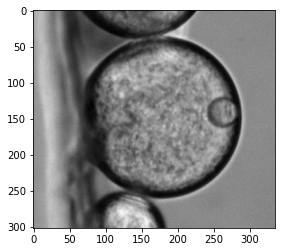

In [308]:
# show image 1 and manually crop
img = io.imread(l.Dir[568])
plt.imshow(img, cmap='gray')

<font color='red'> Set `crop_anchor` and `crop_size` so that inner drop is the majority of the cropped image

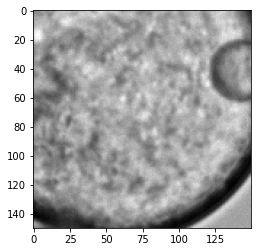

In [309]:
# test the first cropped image
crop_anchor_init = np.array([100, 120]) # upper left corner coords, int
crop_size = (150, 150) # height and width, int
crop = (crop_anchor_init[0], crop_anchor_init[0]+crop_size[0],
       crop_anchor_init[1], crop_anchor_init[1]+crop_size[1])
# need to check if the crop exceeds the borders of images
cropped = img[crop[0]:crop[1], crop[2]:crop[3]]
plt.imshow(cropped, cmap='gray')

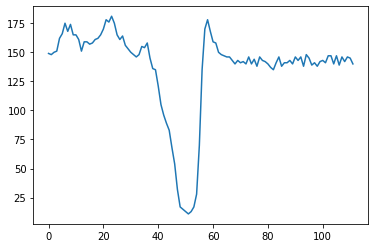

In [184]:
plt.plot(cropped[80, :])

<font color='red'> Set `Hough_maxRadius` and `Hough_minRadius`, in cases where no circle can be detected or the circle detected is way off, modify `Hough_dp`  

circles:  [[[65.450005 41.25     24.18    ]]]
Wall time: 21 ms


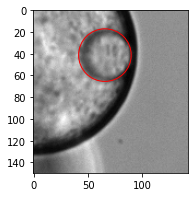

In [190]:
%%time
# test HoughCircles params

Hough_dp_init = 1.1
Hough_param2_init = 1
Hough_maxRadius_init = 26
Hough_minRadius_init = 20
Hough_minDist_init = max(crop_size) # Hough_minRadius // 2
circles = cv2.HoughCircles(to8bit(cropped), cv2.HOUGH_GRADIENT, Hough_dp_init, Hough_minDist_init, 
                               param2=Hough_param2_init, maxRadius=Hough_maxRadius_init, minRadius=Hough_minRadius_init)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(to8bit(cropped), cmap='gray')
circle_object = mpatch.Circle((circles[0, 0, 0], circles[0, 0, 1]), circles[0, 0, 2],
                             fill=False, ec='red', lw=1)
ax.add_patch(circle_object)
print("circles: ", circles)

In [99]:
circles

array([[[135., 195.,  59.]]], dtype=float32)

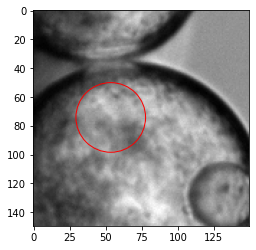

 [###########################################################-] 99.8%


In [191]:
# Initial params
# crop_anchor = np.array([190, 140]) # upper left corner coords, int
# crop_size = (90, 90) # height and width, int
save_crop_step = 1 # save cropped image every save_crop_step steps, int
number_of_circles = 1 # number of circles to be detected, the idea is to detect multiple circles and use linking criteria to filter out false detection
start_frame = 0
end_frame = None
img_list = l.reset_index()
num_images = len(img_list)

# HoughCircles params
Hough_dp = Hough_dp_init
Hough_minDist = Hough_minDist_init
Hough_param2 = Hough_param2_init
Hough_maxRadius = Hough_maxRadius_init
Hough_minRadius = Hough_minRadius_init
crop_anchor = crop_anchor_init

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame

# initialize output folder
main_output_folder = os.path.join(folder, 'Analysis', '{:02d}'.format(n))
cropped_folder = os.path.join(main_output_folder, 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)

print("start working on {}".format(folder))

for num, i in img_list.iterrows():
    if num < start_frame:
        continue
    # read image and convert to 8-bit (HoughCircles requires 8-bit images)
    img = to8bit(io.imread(i.Dir))

    # set crop using crop_anchor and crop_size
    crop = (crop_anchor[0], crop_anchor[0]+crop_size[0],
           crop_anchor[1], crop_anchor[1]+crop_size[1])
    # need to check if the crop exceeds the borders of images
    cropped = img[max(crop[0], 0):min(crop[1], img.shape[0]), max(crop[2], 0):min(crop[3], img.shape[1])]
    # use HoughCircles to detect circles in the cropped image
    circles = cv2.HoughCircles(cropped, cv2.HOUGH_GRADIENT, Hough_dp, Hough_minDist, 
                               param2=Hough_param2, maxRadius=Hough_maxRadius, minRadius=Hough_minRadius)
    if circles is not None: # check if any circle is detected
        x, y = circles[0, 0, 0]+crop_anchor[1], circles[0, 0, 1]+crop_anchor[0]
        # NOTE: the circle coords given by HoughCircles is in (x, y), i.e. horizontal then vertical 
        #       to be consistent with the row-column coords, we need to put circles[0,0,1] as the "row" #
        #       and circles[0,0,0] as the "column" #
        
        # update crop_anchor with the position of circle detected
        crop_anchor = np.array([y-crop_size[1]/2, x-crop_size[0]/2]).astype('int')
        if num % save_crop_step == 0: # save cropped image and detecting result for validating purpose
            fig = plt.figure(figsize=(3, 3))
            ax = fig.add_axes([0,0,1,1])
            ax.imshow(cropped, cmap='gray')
            for circle in circles[0][:number_of_circles]:
                circle_object = mpatch.Circle((circle[0], circle[1]), circle[2],
                                             fill=False, ec='red', lw=1)
                ax.add_patch(circle_object)
            fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
            plt.pause(0.01)
            plt.close() # prevent figure from showing up inline
            show_progress(num/num_images)
            clear_output(wait=True)
    else:
        # if no circle is detected, set x, y to NaN
        x, y = np.nan, np.nan
    
    # record information from each step in lists
    filename_list.append(i.Name)
    x_list.append(x)
    y_list.append(y) 
        
    # check end_frame
    if end_frame is not None:
        if num >= end_frame-1:
            break

data = pd.DataFrame({'x':x_list, 'y':y_list, 'filename':filename_list})
data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)

(0.0, 5000.0)

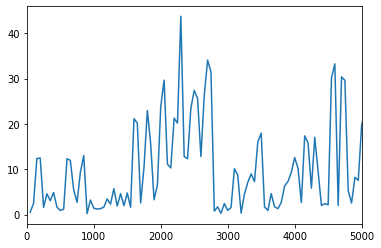

In [146]:
disp = (data.x.diff() ** 2 + data.y.diff() ** 2) ** 0.5
plt.plot(disp.index*50, disp)
plt.xlim([0, 5000])

### 0.1 Larger crop_size helps

Intuitively, the optimal `crop_size` is equal to the diameter of the circle to be detected. However, in practice, a little larger `crop_size` gives the program space to correct mistakes. This idea is illustrated in the picture below:

![](../images/2022/06/crop-size-effect.PNG)

When `crop_size=90`, the circle detection fails at the 4th image, because the edge of droplet touches the image boundary and affects the gradient computation. Because of this false detection, the droplet in the 5th cropped image is not even intact, so that detecting that partial circle becomes more difficult. Consequently, the small mistake in the 4th image leads to false detection in all the following images. 

When `crop_size=100`, a false detection on the 4th image is also observed. However, the program is able to detect correctly in the following images, because the droplet is still intact in the cropped images. 

From this comparison, we conclude that it is practically beneficial to have larger `crop_size`.

## 1 Whole image tracking and multiple detections per frame

Although I know that I only want to track one droplet, and the current code will only return the best circle (the highest score feature in the accumulator) due to the large `minDist` setting, sometimes the droplet I want to track is not the best circle. 

If we track multiple circles in an image, and then use the `link` function in tracking analysis, we might be able to detect the droplets in more frames.

In this scheme, since we won't know which circle is the actual droplet we are looking for, using the position of frame 1 to crop frame 2 is not a good idea. Therefore, we run the circle detection on full images.

In [107]:
folder = r'C:\Users\liuzy\Documents\05312022'
n = 6
l = readdata(os.path.join(folder, '{:02d}'.format(n)), 'tif')
num_images = len(l)
print('Total {:d} frames'.format(num_images))

Total 600 frames


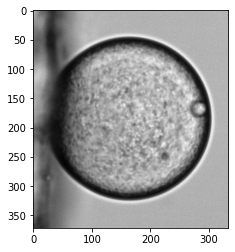

In [108]:
# show image 1 and manually crop
img = io.imread(l.Dir[0])
plt.imshow(img, cmap='gray')

<font color='red'> Set `Hough_maxRadius` and `Hough_minRadius`, in cases where no circle can be detected or the circle detected is way off, modify `Hough_dp`  

circles detected:  2
Wall time: 20.9 ms


array([[269.5, 157.5,  11. ],
       [236.5, 266.5,  14.4]], dtype=float32)

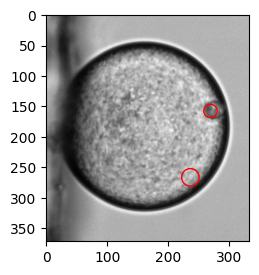

In [129]:
%%time
# test HoughCircles params


params_init = {"dp"       : 1    , 
               "minDist"  :  15,
               "param1"   :  200   , 
               "param2"   :  12, 
               "maxRadius":  15,
               "minRadius":  8}
# Hough_minDist_init = params_init["maxRadius"]
# circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, Hough_dp_init, Hough_minDist_init, param1=Hough_param1_init,
#                                param2=Hough_param2_init, maxRadius=Hough_maxRadius_init, minRadius=Hough_minRadius_init)
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, **params_init)

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.imshow(img, cmap='gray')
for circle in circles[0][:5]:
    circle_object = mpatch.Circle((circle[0], circle[1]), circle[2],
                                 fill=False, ec='red', lw=1)
    ax.add_patch(circle_object)
print("circles detected: ", circles.shape[1])
circles[0][:5]

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

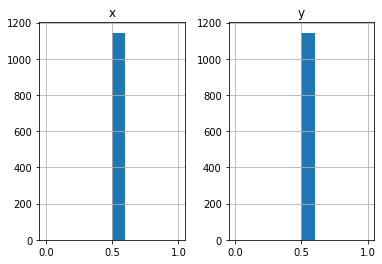

In [130]:
# Initial params
save_step = 100 # save detection overlay image every save_step steps, int
number_of_circles = 3 # number of circles to be detected, the idea is to detect multiple circles and use linking criteria to filter out false detection
start_frame = 0
end_frame = None
img_list = l.reset_index()
num_images = len(img_list)

# HoughCircles params
params = params_init

# initialize result containers
x_list = [] # x of circle
y_list = [] # y of circle
filename_list = [] # filename of raw image
nc_list = [] # number of circles detected in each frame
data_list = []

# initialize output folder
main_output_folder = os.path.join(folder, 'Analysis', '{:02d}'.format(n))
cropped_folder = os.path.join(main_output_folder, 'cropped')
if os.path.exists(main_output_folder) == False:
    os.makedirs(main_output_folder)
if os.path.exists(cropped_folder) == False:
    os.makedirs(cropped_folder)



for num, i in img_list.iterrows():
    if num < start_frame:
        continue
    # read image and convert to 8-bit (HoughCircles requires 8-bit images)
    
    img = to8bit(io.imread(i.Dir))
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(img, cmap='gray')
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, **params)
    
    if circles is not None: # check if any circle is detected        
        for circle in circles[0][:number_of_circles]:            
            data_item = pd.DataFrame({"x": circle[0], 
                                      "y": circle[1], 
                                      "r": circle[2],
                                      "filename": i.Name}, index=[0])
            data_list.append(data_item)       
            circle_object = mpatch.Circle((circle[0], circle[1]), circle[2],
                                     fill=False, ec='red', lw=1)
            ax.add_patch(circle_object)  
    else:
        # if no circle is detected, set x, y to NaN
        # x, y = np.nan, np.nan
        data_item = pd.DataFrame({"x": np.nan, 
                                  "y": np.nan, 
                                  "r": np.nan,
                                  "filename": i.Name}, index=[0])
        data_list.append(data_item)

    if num % save_step == 0: # save image and detecting result for validating purpose
        fig.savefig(os.path.join(cropped_folder, '{}.jpg'.format(i.Name)))
    plt.pause(0.01)
    plt.close() # prevent figure from showing up inline
    show_progress((num+1)/num_images)
    clear_output(wait=True)

    data = pd.concat(data_list, axis=0)

    if end_frame is not None:
        if num >= end_frame-1:
            break

# save traj data in a *.csv file
data.to_csv(os.path.join(main_output_folder, 'traj.csv'), index=False)
# save HoughCircles params in a *.json file for future ref
with open(os.path.join(main_output_folder, "hough_params.json"), "w") as f:
    f.write(json.dumps(params))
# show the subpixel bias analysis
tp.subpx_bias(data)

### Link droplet trajectory

In [182]:
data = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "traj1.csv"))
traj = data.assign(frame=data.filename.astype("int")//50)

In [183]:
t = tp.link(traj, 30, memory=5)
t1 = tp.filter_stubs(t, 10)

Frame 599: 2 trajectories present.


([<matplotlib.axis.XTick at 0x21b20f0d460>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

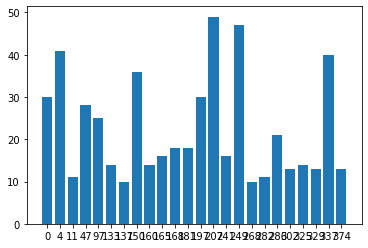

In [184]:
# particle number histogram
count_list = []
for _, g in t1.groupby("particle"):
    count_list.append(len(g))
plt.bar(t1.particle.drop_duplicates().astype("string"), count_list)
plt.xticks(t1.particle.drop_duplicates().astype("string"))

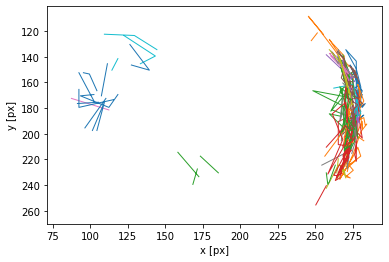

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [185]:
tp.plot_traj(t1)

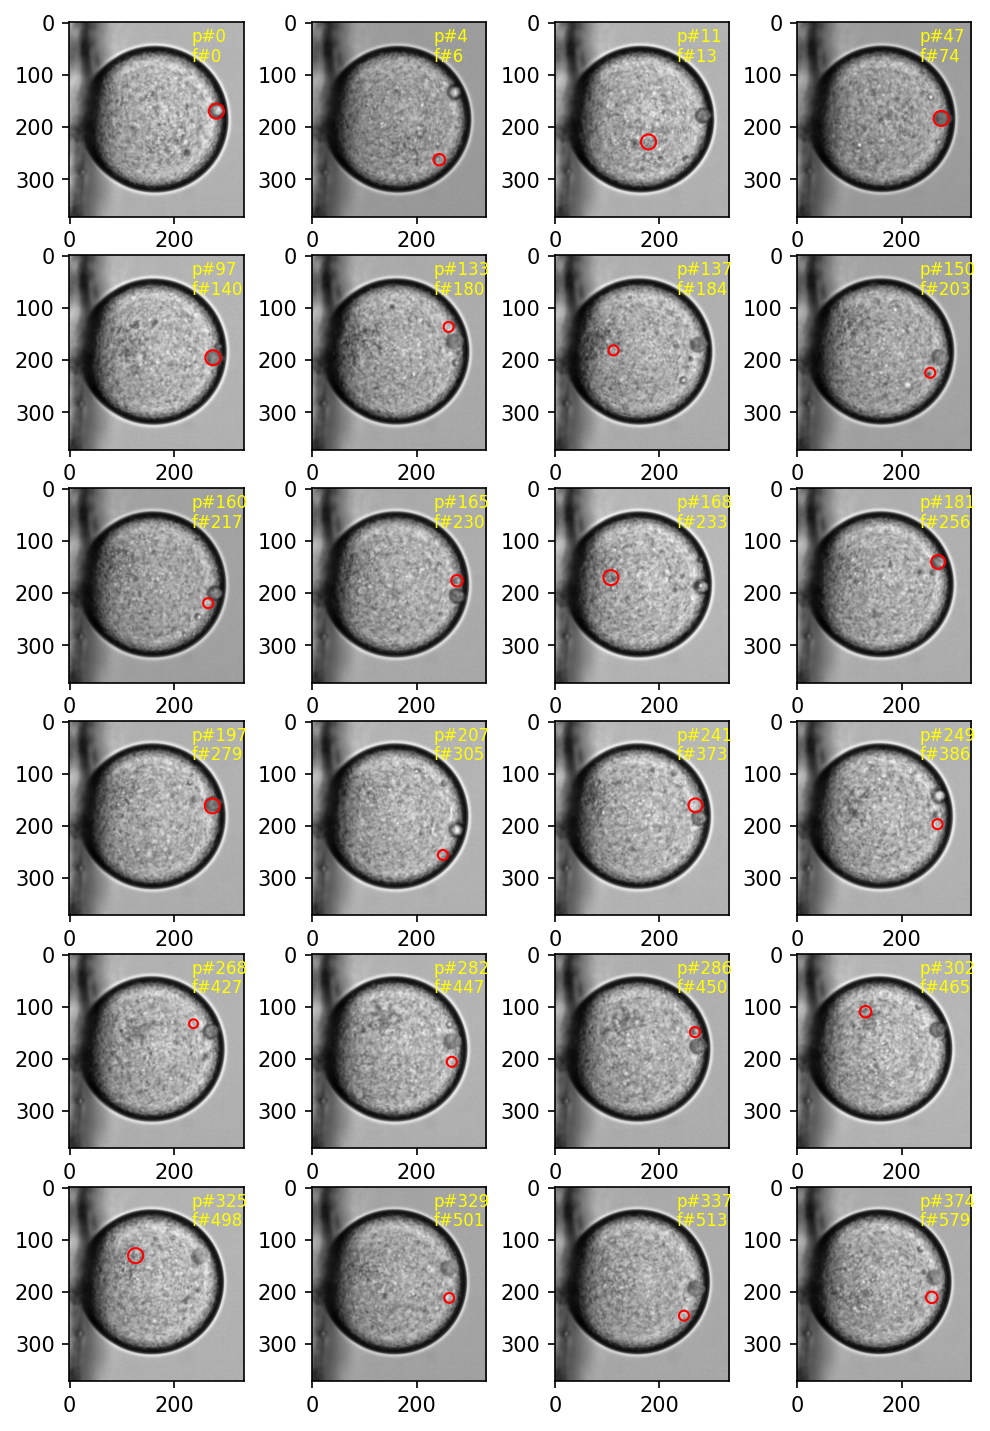

In [199]:
# check which particle is True inner droplet and which is false detection
n_images = len(t1.particle.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1
for particle in t1.particle.drop_duplicates():
    sub_traj = t1.loc[t1.particle==particle]
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    for num, i in sub_traj.iterrows():   
        img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(int(i.filename))))
        ax.imshow(img, cmap="gray")
        circle_object = mpatch.Circle((i.x, i.y), i.r, 
                                     fill=False, ec='red', lw=1)
        ax.add_patch(circle_object)
        ax.annotate("p#{:d}".format(particle), (0.7, 0.9), xycoords="axes fraction", color="yellow", fontsize=8)
        ax.annotate("f#{:d}".format(int(i.frame)), (0.7, 0.8), xycoords="axes fraction", color="yellow", fontsize=8)
#         plt.pause(0.1)
#         plt.close()
        break

In [200]:
t1 = t1.query("particle in [0, 47, 97, 138, 150, 160, 165, 181, 197, 207, 241, 249, 282, 285, 329, 337, 374]")

In [202]:
# print duplicated frames (frames with more than 1 particles)
dup = pd.concat(g for _, g in t1.drop(columns=["frame"]).groupby("frame") if len(g) > 1)
dup.head()

x      y     r  filename  particle
frame                                        
217    276.5  199.5  14.4     10850       150
217    265.5  219.5   9.6     10850       160
218    273.5  186.5  13.2     10900       150
218    264.5  230.5  13.2     10900       160
223    277.5  180.5  14.4     11150       150

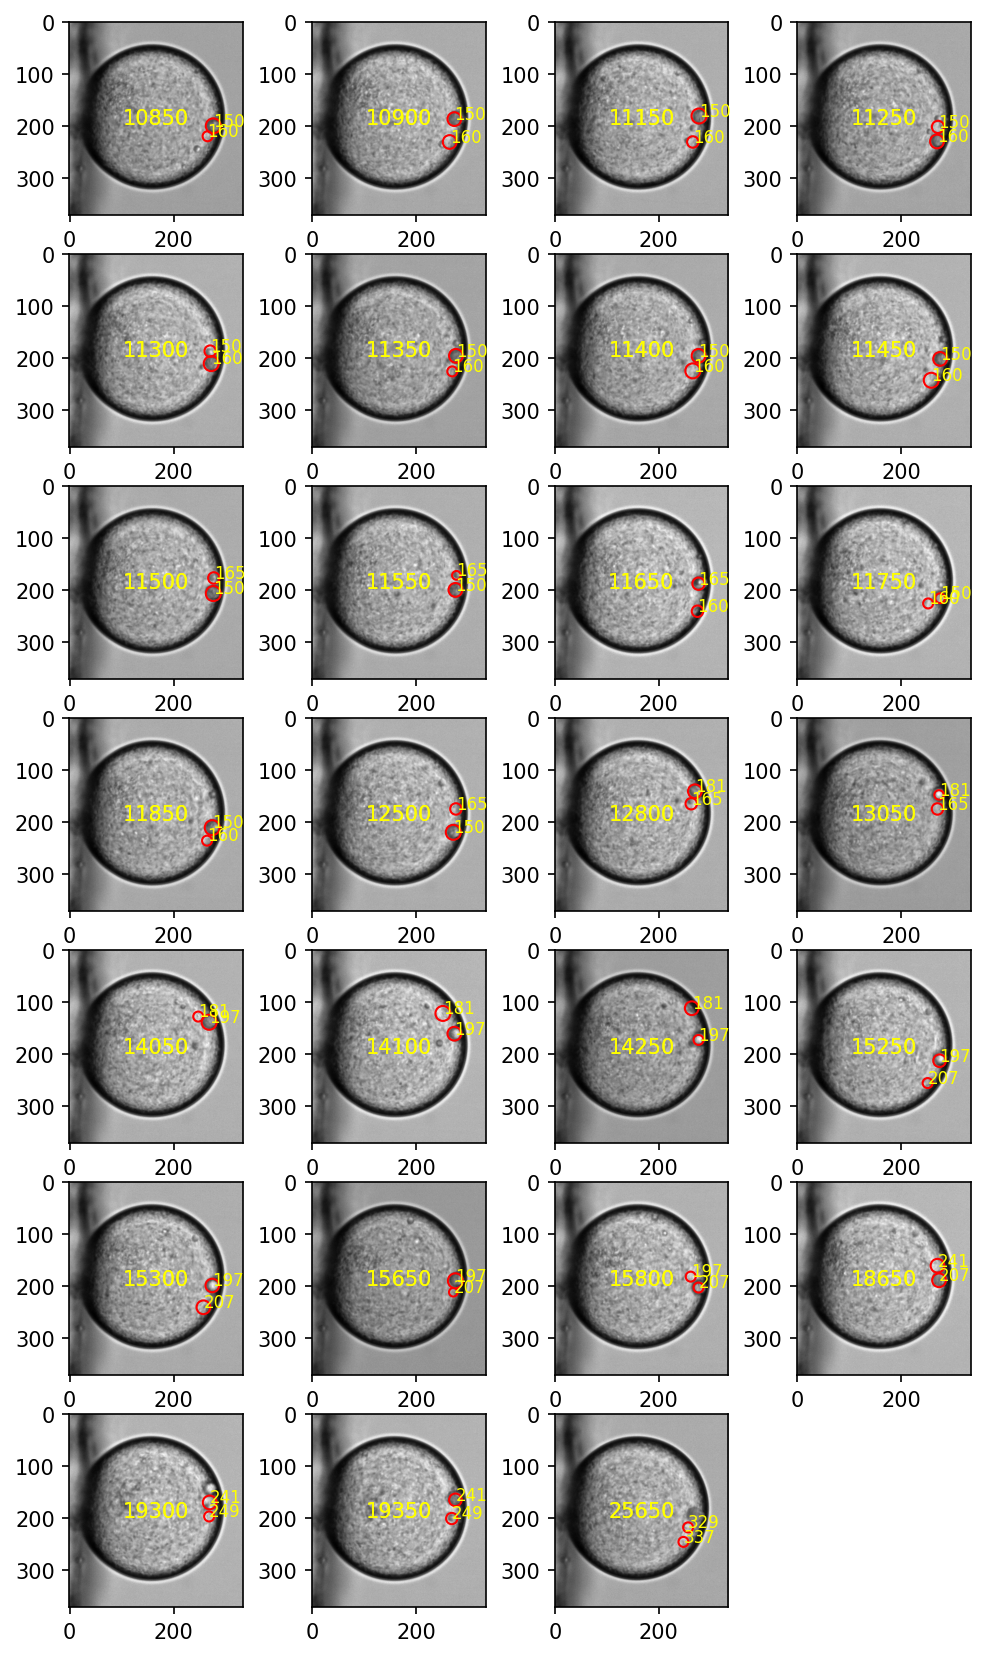

In [205]:
# plot duplicates
n_images = len(dup.filename.drop_duplicates())
ncols = 4
nrows = n_images // ncols
if n_images % ncols != 0:
    nrows += 1
fig = plt.figure(figsize=(2*ncols, 2*nrows), dpi=150)
count = 1

for filename in dup.filename.drop_duplicates():
    ax = fig.add_subplot(nrows, ncols, count)
    count += 1
    img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(int(filename))))
    subdata = dup.loc[dup.filename==filename]
    ax.imshow(img, cmap="gray")
    for num, i in subdata.iterrows():
        circle_object = mpatch.Circle((i.x, i.y), i.r, fill=False, ec="red", lw=1)
        ax.add_patch(circle_object)
        ax.annotate("{:d}".format(int(i.particle)), (i.x, i.y), color="yellow", fontsize=8)
        ax.annotate("{:d}".format(int(i.filename)), (0.5, 0.5), 
                    color="yellow", xycoords="axes fraction",
                    verticalalignment="center", horizontalalignment="center")

In [166]:
t1.to_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t.csv"), index=False)

In [145]:
t1.frame *= 50

C:\Users\liuzy\Miniconda3\lib\site-packages\pandas\core\generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [63]:
t1.particle = 0

C:\Users\liuzy\Miniconda3\lib\site-packages\pandas\core\generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


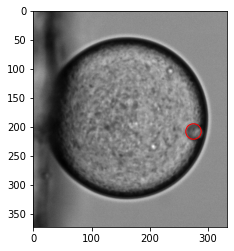

KeyboardInterrupt: 

In [206]:
# verify tracking quality
folder = r"C:\Users\liuzy\Documents\05312022"
n = 6
t1 = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t1.csv"))
for _, i in t1.iterrows():
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(int(i.frame))))
    ax.imshow(img, cmap="gray")
    circle_object = mpatch.Circle((i.x, i.y), i.r, fill=False, ec="red", lw=1)
    ax.add_patch(circle_object)
    plt.pause(0.01)
    clear_output(wait=True)

### Compare two trackings

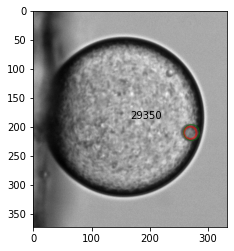

In [175]:
# Compare two trackings
folder = r"C:\Users\liuzy\Documents\05312022"
n = 6
traj1 = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                 "t.csv")).set_index("frame")
traj2 = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                 "t1c.csv")).set_index("frame")
traj1.index = traj1.index.astype("int")
traj2.index = traj2.index.astype("int")
combine_traj = pd.concat([traj1, traj2], axis=1, keys=["traj1", "traj2"])

for num, i in combine_traj.iterrows():
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0,0,1,1])
    img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(num)))
    ax.imshow(img, cmap="gray")
    c1 = mpatch.Circle((i["traj1"].x, i["traj1"].y), i["traj1"].r, 
                       fill=False, ec="red", lw=2, alpha=0.5)
    c2 = mpatch.Circle((i["traj2"].x, i["traj2"].y), i["traj2"].r, 
                       fill=False, ec="green", lw=1, alpha=0.5)
    ax.annotate("{:05d}".format(int(num)), (0.5, 0.5), xycoords="axes fraction")
    ax.add_patch(c1)
    ax.add_patch(c2)
    plt.pause(.01)
    plt.close()
    clear_output(wait=True)
#     if num == 0:
#         break

### Overview of the tracking results

This section provides an overview of the tracking, to see if the quality is satisfactory. This will include:
1. x time series: inner, outer, subtraction
2. y time series: inner, outer, subtraction
3. droplet size time series: outer and inner
4. sketch of inner droplet trajectory
5. subpixel bias: x, y, subtraction

In [64]:
outer_traj.sample().x.values[0]

-6.520288998599213

## 2 Subpixel accuracy

The Hough Circles algorithm works well in detecting circle objects in images. However, the accuracy in this implementation is not great, as the position resolution is only 1 pixel (all the positions of circles detected are xx.5). 

### 2.1 Cross-boundary Gaussian fitting (and local minimum correction)

A possible way to achieve subpixel accuracy is to find maxima in cross-boundary intensity profiles and modify the original detected position. 

Here, we want to design a function, which takes in the original circle detection information (x0, y0, r0), as well as the raw image, and use cross-boundary intensity profile fitting to return a corrected circle detection (x1, y1, r1).

### 2.2 Compare circle detection quality

We need a metric of circle detection quality. An intuitive metric is the standard deviation of boundary pixel intensities. A good circle should have smaller variation in boundary pixel intensities, hence smaller standard deviation.

In [420]:
folder = r"C:\Users\liuzy\Documents\06032022"
n = 0
raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "00000.tif"))
inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "traj1.csv"))
x0, y0, r0 = inner_traj.x.iloc[0], inner_traj.y.iloc[0], inner_traj.r.iloc[0]
original_circle = {"x": x0, "y": y0, "r": r0}
corrected_circle = subpixel_correction_minimum(original_circle, raw_img, range_factor=0.6, plot=False, thres=10)

circle radius: 14.3
distsq threshold: 10
number of pixels on circle: 65
std circle: 21.56
std img: 35.58
quality original: -0.15
quality: 0.39


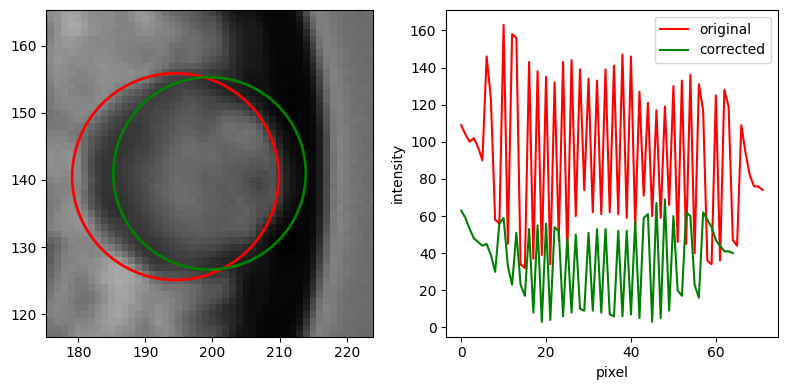

In [423]:
# get all the pixel coords on the circle
x0, y0, r0 = original_circle["x"], original_circle["y"], original_circle["r"]
x, y, r = corrected_circle["x"], corrected_circle["y"], corrected_circle["r"]
# 1. make X, Y coordinates of all image pixels
Y, X = np.mgrid[0:raw_img.shape[0], 0:raw_img.shape[1]]
# 2. compute distance (square) matrix from each pixel to circle center
dist = (X-x) ** 2 + (Y-y) ** 2 - r ** 2 
dist_o = (X-x0) ** 2 + (Y-y0) ** 2 - r0 ** 2 
# 3. make a boolean matrix ind where the distance is smaller than 5 (note that 5 is an arbitrary number and need revision)
distsq_thres = 10
ind = abs(dist) < distsq_thres
ind_o = abs(dist_o) < distsq_thres
# 4. use the ind matrix to get all the pixel intensity values on the detected circle
original_circle_pixels = raw_img[ind_o]
circle_pixels = raw_img[ind]
# 5. compute standard deviation of circle_pixels
std = circle_pixels.std()
std_o = original_circle_pixels.std()
std_img = raw_img.std()
print("circle radius: {:.1f}".format(r))
print("distsq threshold: {:d}".format(distsq_thres))
print("number of pixels on circle: {:d}".format(len(circle_pixels)))
print("std circle: {:.2f}".format(std))
print("std img: {:.2f}".format(std_img))
print("quality original: {:.2f}".format(1-std_o/std_img))
print("quality: {:.2f}".format(1-std/std_img))
# 6. plot the process
fig = plt.figure(figsize=(8, 4), dpi=100)
ax1 = fig.add_subplot(121)
ax1.imshow(raw_img, cmap="gray")
ax1.set_xlim([x-r-10, x+r+10])
ax1.set_ylim([y-r-10, y+r+10])
cobj = mpatch.Circle((x0, y0), r0, fill=False, ec="red", lw=2)
ax1.add_patch(cobj)
ccor = mpatch.Circle((x, y), r, fill=False, ec="green", lw=2)
ax1.add_patch(ccor)
ax2 = fig.add_subplot(122)
ax2.plot(original_circle_pixels, color="red", label="original")
ax2.plot(circle_pixels, color="green", label="corrected")
ax2.legend()
ax2.set_xlabel("pixel")
ax2.set_ylabel("intensity")
plt.tight_layout()

### Try the quality metric on a whole trajectory / image sequence

This is a working section for batch traj correction.

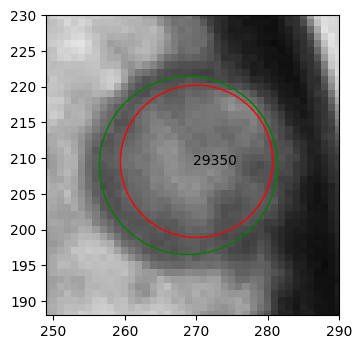

 [###########################################################-] 99.6%
time: 42.3 s | processing speed: 5.4 frame/s


In [176]:
folder = r"C:\Users\liuzy\Documents\05312022"
n = 6
save_step = 100 # save a snapshot every save_step steps

correction_params = {"range_factor": 0.4,
                     "thres": 5,
                     "method": "minimum",
                     "plot": False}

circle_list = []
original_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                         "t1.csv")).set_index("filename")
n_frames = len(original_traj)
count = 0
analysis_folder = os.path.join(folder, "Analysis", "{:02d}".format(n))
snapshot_folder = os.path.join(analysis_folder, "cropped")
if os.path.exists(snapshot_folder) == False:
    os.makedirs(snapshot_folder)
t0 = time.monotonic()
for num, i in original_traj.iterrows():
    original_circle = {"x": i.x, "y": i.y, "r": i.r}
    raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(num)))
#     try:
#         corrected_circle = subpixel_correction_gaussian(original_circle, raw_img, range_factor=0.5, plot=True, thres=30)
#     except:
#         corrected_circle = original_circle
    corrected_circle = subpixel_correction(original_circle, raw_img, **correction_params)
    original_quality = circle_quality_std(raw_img, original_circle)
    corrected_quality = circle_quality_std(raw_img, corrected_circle)
    corrected_circle["frame"] = num
    corrected_circle["original_quality"] = original_quality
    corrected_circle["corrected_quality"] = corrected_quality
    circle_list.append(pd.DataFrame(corrected_circle, index=[num]))
    
    
    fig = plt.figure(figsize=(3,3), dpi=100)
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(raw_img, cmap="gray")
    cobj = mpatch.Circle((original_circle["x"], original_circle["y"]), original_circle["r"], fill=False, ec="red", lw=1)
    ax.add_patch(cobj)
    ccor = mpatch.Circle((corrected_circle["x"], corrected_circle["y"]), corrected_circle["r"], fill=False, ec="green", lw=1)
    ax.add_patch(ccor)
    ax.set_xlim([int(original_circle["x"]-original_circle["r"]-10), int(original_circle["x"]+original_circle["r"]+10)])
    ax.set_ylim([int(original_circle["y"]-original_circle["r"]-10), int(original_circle["y"]+original_circle["r"]+10)])
    ax.annotate(num, (0.5, 0.5), xycoords="axes fraction")    
    if count % save_step == 0:        
        fig.savefig(os.path.join(snapshot_folder, "{:05d}.jpg".format(num)))
    plt.pause(0.01)
    plt.close()
    show_progress(count / n_frames)
    t1 = time.monotonic()-t0
    print("time: {0:.1f} s | processing speed: {1:.1f} frame/s".format(t1, count/t1))
    clear_output(wait=True)    
    count += 1
corrected_traj = pd.concat(circle_list)
with open(os.path.join(analysis_folder, "correction_params.json"), "w") as f:
    f.write(json.dumps(correction_params))
corrected_traj.to_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t.csv"))

### generate a report of the subpixel correction

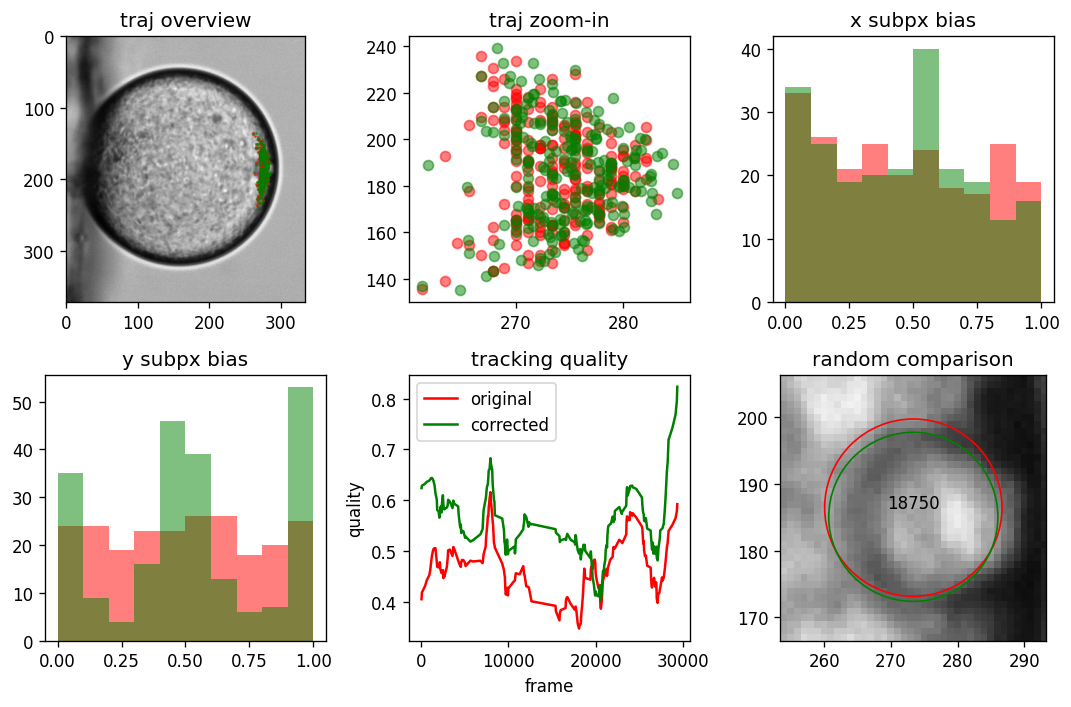

In [178]:
# generate a report of the tracking correction
# 1. zoom out trajectory
# 2. zoom in trajectory
# 3. subpixel bias 
# 4. quality time series
# 5. random correction sample 

folder = r"C:\Users\liuzy\Documents\05312022"
n = 6

original_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                         "t1.csv")).set_index("filename")
corrected_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), 
                                          "t.csv")).set_index("frame")
frame = corrected_traj.sample().index[0]
raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "{:05d}.tif".format(frame)))

fig = plt.figure(figsize=(9, 6), dpi=120)
ax1 = fig.add_subplot(231)
ax1.set_title("traj overview")
ax1.imshow(raw_img, cmap="gray")
ax1.scatter(original_traj.x, original_traj.y, color="red", s=1, alpha=0.5)
ax1.scatter(corrected_traj.x, corrected_traj.y, color="green",s=1, alpha=0.5)

ax2 = fig.add_subplot(232)
ax2.set_title("traj zoom-in")
ax2.scatter(original_traj.x, original_traj.y, color="red", alpha=0.5)
ax2.scatter(corrected_traj.x, corrected_traj.y, color="green", alpha=0.5)

ax3 = fig.add_subplot(233)
ax3.set_title("x subpx bias")
histx, bin_edges = np.histogram(original_traj.x - original_traj.x.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax3.bar(bin_edges[:-1], histx, 
        align="edge", width=bin_edges[1]-bin_edges[0], 
        color="red", alpha=0.5, label="original")
histx, bin_edges = np.histogram(corrected_traj.x - corrected_traj.x.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax3.bar(bin_edges[:-1], histx, 
        align="edge", width=bin_edges[1]-bin_edges[0], 
        color="green", alpha=0.5, label="corrected")

ax4 = fig.add_subplot(234)
ax4.set_title("y subpx bias")
histx, bin_edges = np.histogram(original_traj.y - original_traj.y.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax4.bar(bin_edges[:-1], histx, 
        align="edge", width=bin_edges[1]-bin_edges[0], 
        color="red", alpha=0.5, label="original")
histx, bin_edges = np.histogram(corrected_traj.y - corrected_traj.y.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax4.bar(bin_edges[:-1], histx, 
        align="edge", width=bin_edges[1]-bin_edges[0], 
        color="green", alpha=0.5, label="corrected")

ax5 = fig.add_subplot(235)
ax5.set_title("tracking quality")
ax5.plot(corrected_traj.index, savgol_filter(corrected_traj.original_quality, 31, 2), color="red", label="original")
ax5.plot(corrected_traj.index, savgol_filter(corrected_traj.corrected_quality, 31, 2), color="green", label="corrected")
ax5.set_xlabel("frame")
ax5.set_ylabel("quality")
ax5.legend()

ax6 = fig.add_subplot(236)
ax6.set_title("random comparison")
ax6.imshow(raw_img, cmap="gray")
co = mpatch.Circle((original_traj.loc[frame].x, original_traj.loc[frame].y), original_traj.loc[frame].r,
                   fill=False, ec="red", lw=1) 
cc = mpatch.Circle((corrected_traj.loc[frame].x, corrected_traj.loc[frame].y), corrected_traj.loc[frame].r,
                   fill=False, ec="green", lw=1)
ax6.add_patch(co)
ax6.add_patch(cc)
roi_factor = 1.5
ax6.set_xlim([original_traj.loc[frame].x - roi_factor*original_traj.loc[frame].r, original_traj.loc[frame].x + roi_factor*original_traj.loc[frame].r])
ax6.set_ylim([original_traj.loc[frame].y - roi_factor*original_traj.loc[frame].r, original_traj.loc[frame].y + roi_factor*original_traj.loc[frame].r])
ax6.annotate(frame, (0.5, 0.5), xycoords="axes fraction", horizontalalignment="center")
plt.tight_layout()

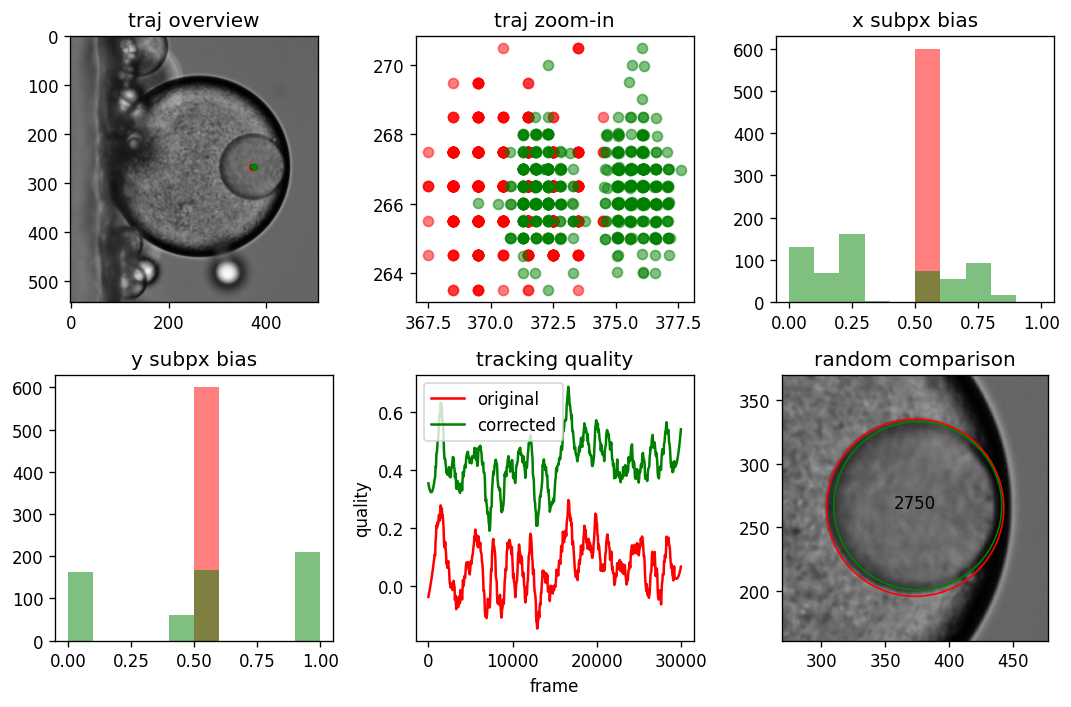

In [162]:
folders = ["06012022", "06022022", "06032022"]
correction_params = {"range_factor": 0.4,
                     "thres": 10,
                     "method": "minimum",
                     "plot": False}
for f in folders:
    folder = os.path.join(r"C:\Users\liuzy\Documents", f)
    analysis_folder = os.path.join(folder, "Analysis")
    sfL = next(os.walk(analysis_folder))[1]
    for sf in sfL:
        n = int(sf)
        if f == "06012022" and n == 0:
            continue
        print("{0}-{1:02d}".format(folder, n))
        for filename in ["t0", "t1"]:            
            correct_traj(folder, n, filename, correction_params)
            generate_correction_report(os.path.join(folder, "Analysis", "{:02}".format(n)), filename)

### 2.3 Iterative correction

Sometimes, 1 correction is not enough to give the most accurate position. In this section, we test if iteractive correction can result in better results, and most importantly, convergence. 

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


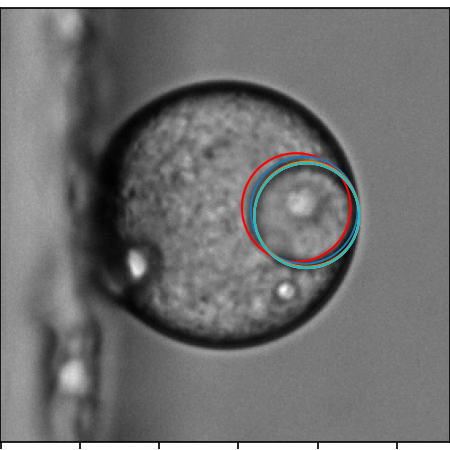

00 | -0.11
01 | 0.09
02 | 0.30
03 | 0.26
04 | 0.31
05 | 0.31
06 | 0.31
07 | 0.31
08 | 0.31
09 | 0.31


In [11]:
%matplotlib
folder = r"C:\Users\liuzy\Documents\06022022"
n = 2
raw_img = io.imread(os.path.join(folder, "{:02d}".format(n), "00000.tif"))
inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t1.csv"))
x0, y0, r0 = inner_traj.x.iloc[0], inner_traj.y.iloc[0], inner_traj.r.iloc[0]
circle = {"x": x0, "y": y0, "r": r0}
cobj = mpatch.Circle((circle["x"], circle["y"]), circle["r"], fill=False, ec="red", lw=1)
    
fig = plt.figure(figsize=(3, 3), dpi=150)
ax = fig.add_axes([0,0,1,1])
ax.imshow(raw_img, cmap="gray")
ax.add_patch(cobj)   
it = 0
while it < 10: 
    q = circle_quality_std(raw_img, circle, distsq_thres=10)
    print("{:02d} | {:.2f}".format(it, q))
    circle = subpixel_correction(circle, raw_img, range_factor=0.5, 
                                             plot=False, thres=10, method="minimum", sample=20)   
    ccor = mpatch.Circle((circle["x"], circle["y"]), circle["r"], fill=False, ec=bestcolor(it), lw=1)
    ax.add_patch(ccor)
    it += 1

So with an appropriate correction setting, the iterative scheme can indeed improve the correction quality, and converge to a good result. 

## 3 Post processing

### 3.1 Subtract outer traj from inner traj

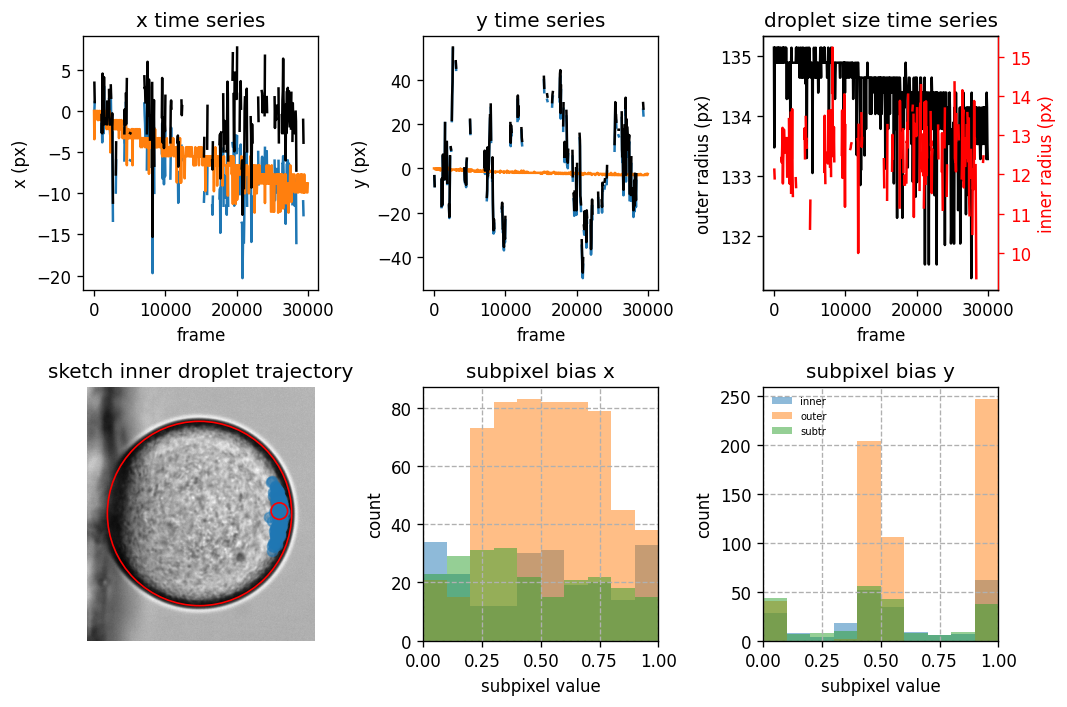

In [179]:
# working code for subtraction
folder = r"C:\Users\liuzy\Documents\05312022"
n = 6 
img = io.imread(os.path.join(folder, "{:02d}".format(n), "00000.tif"))
outer_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t0c.csv")).set_index("frame")
inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t1c.csv")).set_index("frame")

if outer_traj.original_quality.mean() > outer_traj.corrected_quality.mean():
    outer_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t0.csv")).set_index("frame")

if inner_traj.original_quality.mean() > inner_traj.corrected_quality.mean():
    inner_traj = pd.read_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "t1.csv")).set_index("frame")


outer_traj.index = outer_traj.index.astype("int")
inner_traj.index = inner_traj.index.astype("int")
# get initial outer center and inner center
x0, y0, r0 = outer_traj.x.iloc[0], outer_traj.y.iloc[0], outer_traj.r.iloc[0]
x1, y1, r1 = inner_traj.x.iloc[0], inner_traj.y.iloc[0], inner_traj.r.iloc[0]
# offset x with respective initial position
outer_traj.x -= x0
inner_traj.x -= x1
# offset y with initial outer position
inner_traj.y -= y0
outer_traj.y -= y0

combine_traj = pd.concat([inner_traj, outer_traj], axis=1, keys=["inner", "outer"])

# x time series
fig = plt.figure(figsize=(9, 6), dpi=120)
ax1 = fig.add_subplot(231)
ax1.set_title("x time series")
ax1.plot(combine_traj.index, combine_traj["inner"].x, color=bestcolor(0))
ax1.plot(combine_traj.index, combine_traj["outer"].x, color=bestcolor(1))
ax1.plot(combine_traj.index, combine_traj["inner"].x-combine_traj["outer"].x, color="black")
ax1.set_xlabel("frame")
ax1.set_ylabel("x (px)")

# y time series
ax2 = fig.add_subplot(232)
ax2.set_title("y time series")
ax2.plot(combine_traj.index, combine_traj["inner"].y, color=bestcolor(0))
ax2.plot(combine_traj.index, combine_traj["outer"].y, color=bestcolor(1))
ax2.plot(combine_traj.index, combine_traj["inner"].y-combine_traj["outer"].y, color="black")
ax2.set_xlabel("frame")
ax2.set_ylabel("y (px)")

# droplet size time series
ax3 = fig.add_subplot(233)
ax3.set_title("droplet size time series")
ax3.plot(combine_traj.index, combine_traj["outer"].r, color="black")
ax3.set_ylabel("outer radius (px)")
ax3r = ax3.twinx()
ax3r.spines["right"].set_color("red")
ax3r.yaxis.label.set_color("red")
ax3r.tick_params(axis="y", colors="red")
ax3r.plot(combine_traj.index, combine_traj["inner"].r, color="red")
ax3r.set_ylabel("inner radius (px)")
ax3.set_xlabel("frame")

# sketch of inner droplet trajectory, offset by outer droplet 
ax4 = fig.add_subplot(234)
ax4.set_title("sketch inner droplet trajectory")
ax4.imshow(img, cmap="gray")
ax4.scatter(combine_traj["inner"].x+x1-combine_traj["outer"].x, combine_traj["inner"].y-combine_traj["outer"].y+y0,
           alpha=0.5)
outer_circle = mpatch.Circle((x0, y0), r0, fill=False, ec="red", lw=1)
ax4.add_patch(outer_circle)
inner_circle = mpatch.Circle((x1, y1), r1, fill=False, ec="red", lw=1)
ax4.add_patch(inner_circle)
ax4.axis("off")

# subpixel bias x
ax5 = fig.add_subplot(235)
ax5.set_title("subpixel bias x")
histx, bin_edges = np.histogram(combine_traj["inner"].x - combine_traj["inner"].x.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax5.bar(bin_edges[:-1], histx, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="inner")
histx, bin_edges = np.histogram(combine_traj["outer"].x - combine_traj["outer"].x.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax5.bar(bin_edges[:-1], histx, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="outer")
histx, bin_edges = np.histogram(combine_traj["inner"].x - combine_traj["outer"].x - (combine_traj["inner"].x - combine_traj["outer"].x).apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax5.bar(bin_edges[:-1], histx, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="subtr")

ax5.set_xlim([0, 1])
ax5.grid(ls="--")
ax5.set_xlabel("subpixel value")
ax5.set_ylabel("count")

# subpixel bias y
ax6 = fig.add_subplot(236)
ax6.set_title("subpixel bias y")
histy, bin_edges = np.histogram(combine_traj["inner"].y - combine_traj["inner"].y.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax6.bar(bin_edges[:-1], histy, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="inner")
histy, bin_edges = np.histogram(combine_traj["outer"].y - combine_traj["outer"].y.apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax6.bar(bin_edges[:-1], histy, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="outer")
histy, bin_edges = np.histogram(combine_traj["inner"].y - combine_traj["outer"].y - (combine_traj["inner"].y - combine_traj["outer"].y).apply(np.floor),
                               bins=np.linspace(0, 1, 11))
ax6.bar(bin_edges[:-1], histy, align="edge", width=bin_edges[1]-bin_edges[0], alpha=0.5, label="subtr")

ax6.set_xlim([0, 1])
ax6.grid(ls="--")
ax6.set_xlabel("subpixel value")
ax6.set_ylabel("count")
ax6.legend(frameon=False, fontsize=6)

plt.tight_layout()
fig.savefig(os.path.join(folder, "Analysis", "{:02d}".format(n), "subtract-report.jpg"))
t = subtract_traj(inner_traj, outer_traj)
t = t.assign(particle=0)
t.to_csv(os.path.join(folder, "Analysis", "{:02d}".format(n), "final_traj.csv"))

In [30]:
def subtract_traj(t1, t0):
    """Compute the inner droplet trajectory in outer droplet frame.
    This will fix the constant downward slow motion.
    Args:
    t1 -- inner droplet trajectory, lab frame
    t0 -- outer droplet motion, lab frame
    Returns:
    t -- t1 - t0"""
    combine = pd.concat([t1, t0], axis=1, keys=["t1", "t0"])
    t = pd.DataFrame({"frame": combine.index, 
                      "x": combine["t1"].x - combine["t0"].x, 
                      "y": combine["t1"].y - combine["t0"].y}).set_index("frame")
    return t

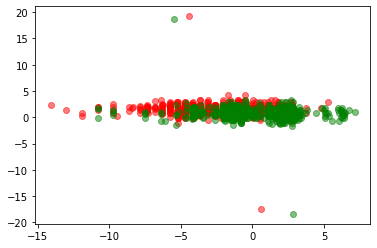

In [39]:
# test sbutract_traj()
folder = r"C:\Users\liuzy\Documents\05312022\Analysis\00"
t0 = pd.read_csv(os.path.join(folder, "t0c.csv"))
if t0.original_quality.mean() > t0.corrected_quality.mean()+0.1:
    t0 = pd.read_csv(os.path.join(folder, "t0.csv"))
t0.frame = t0.frame.astype("int")
t0 = t0.set_index("frame")

t1 = pd.read_csv(os.path.join(folder, "t1c.csv"))
if t1.original_quality.mean() > t1.corrected_quality.mean()+0.1:
    t1 = pd.read_csv(os.path.join(folder, "t1.csv"))
t1.frame = t1.frame.astype("int")
t1 = t1.set_index("frame")

t = subtract_traj(t1, t0)

plt.scatter(t1.x-t1.x.iloc[0], t1.y-t1.y.iloc[0], color="red", alpha=0.5)
plt.scatter(t.x-t.x.iloc[0], t.y-t.y.iloc[0], color="green", alpha=0.5)